### Kaggle Notebook Version
#### For the mini project I want to train a CNN to perform an image classification task on 4 different
#### Artists I like

# Step 1. Create and pre process dataset

Resolving data files:   0%|          | 0/811 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-79c451c404a7e1d5/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Raw Dataset


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 811
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=580x614 at 0x7EF2CEF996C0>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=401x590 at 0x7EF2CEF98CD0>, 'label': 1}




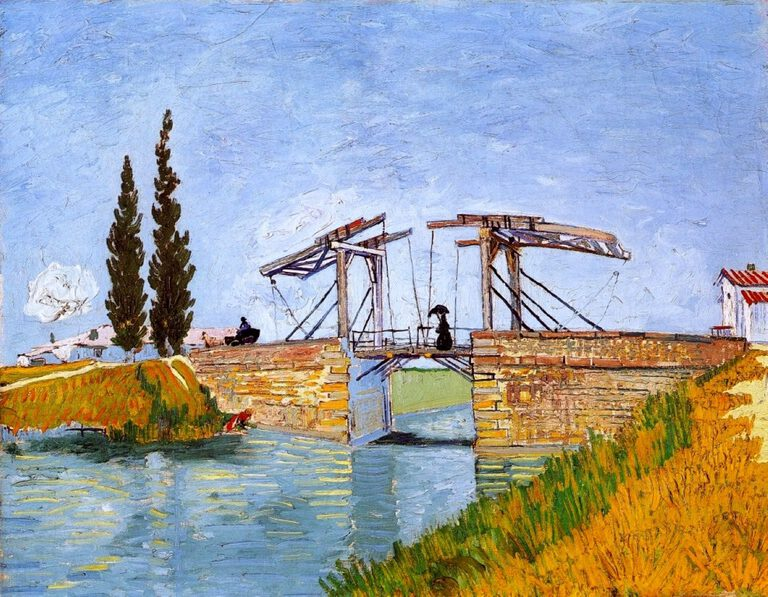

In [1]:
# import Hugging Face datasets
from datasets import load_dataset

#load all images from 11 different artists
raw_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/artist-balanced-sample/Artist_balanced_sample", drop_labels=False)


#Check Raw data set
print("Raw Dataset")
print("\n")
print(raw_dataset)

#Check images size
print(raw_dataset['train'][100])
print(raw_dataset['train'][200])
print('\n')

#We can see that all the images have different sizes so we have to resize them for the CNN

#Check one image of the dataset
raw_dataset['train'][750]['image']

In [2]:
#Define a function to resize the images
def resize_img(dataset):
    dataset["image"] = [image.convert("RGB").resize((224,224)) for image in dataset["image"]]
    return dataset

#And now let's use map function to resize our images
raw_dataset = raw_dataset.map(resize_img, batched=True, batch_size=100)

#check observations again to confirm resizing
print(raw_dataset['train'][100])
print(raw_dataset['train'][200])
print('\n')
print('Resized images')

  0%|          | 0/9 [00:00<?, ?ba/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7EF2CC683F10>, 'label': 0}
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7EF2CC683D00>, 'label': 1}


Resized images


In [3]:
#Finally let's shuffle the dataset and create a train, test split
shuffled_dataset = raw_dataset.shuffle(seed=18)

#Split into train/test 20% for test, and specify seed
shuffled_dataset = shuffled_dataset['train'].train_test_split(test_size=0.2, seed=18)

#check dataset
shuffled_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 648
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 163
    })
})

In [4]:
#Now let's cast our hf dataset to np arrays so that we can use it in keras
import numpy as np
import keras

#Cast images to list of tensors
X_train = [np.expand_dims(np.array(shuffled_dataset['train'][i]['image']),axis=0) 
           for i in range(len(list(shuffled_dataset['train']['image']) ) ) ]

X_test = [np.expand_dims(np.array(shuffled_dataset['test'][i]['image']),axis=0) 
           for i in range(len(list(shuffled_dataset['test']['image']) ) ) ]

#Stack list of tensors
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Normalize values
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

#Cast labels to np arrays
y_train = np.array(list(shuffled_dataset['train']['label']))
y_test = np.array(list(shuffled_dataset['test']['label']))


#One hot encode labels
y_train = keras.utils.to_categorical(y_train, 4)
y_test = keras.utils.to_categorical(y_test, 4)

2024-03-11 23:33:53.629718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 23:33:53.629870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 23:33:53.820095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2. Train CNN to perform Image Classification

## Step 2-1. Train a VGG-like architechtured CNN from scratch

In [5]:
# Instantiate Architechture

#Import libraries
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout

VGG_ish_model = Sequential()
VGG_ish_model.name = "VGG_ish_model"

#First Convolution layer
VGG_ish_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', input_shape=(224,224,3)))
VGG_ish_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# second Convolution layer
VGG_ish_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
VGG_ish_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# third Convolution layer
VGG_ish_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
VGG_ish_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# fourth Convolution Layer
VGG_ish_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
VGG_ish_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# fifth convolution layer
VGG_ish_model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
VGG_ish_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Classification head
VGG_ish_model.add(Flatten())
VGG_ish_model.add(Dense(16, activation='relu'))
VGG_ish_model.add(Dropout(0.5))
VGG_ish_model.add(Dense(16, activation='relu'))
VGG_ish_model.add(Dropout(0.5))
VGG_ish_model.add(Dense(4, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
# Check Model Summary
VGG_ish_model.summary()

Model: "VGG_ish_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       401,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,340 (7.52 MB)

 Trainable params: 1,970,340 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Set Optimizer and compile model
import keras

#Schedule a reduce on lr when validation loss hits a plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

#use the same optimezer used in VGG19
optimizer = keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)

#compile model
VGG_ish_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
#Now let's train our model !
import time #I want to measure how much it takes to train this

start = time.time()
hist = VGG_ish_model.fit(x=X_train, y=y_train, batch_size=5, epochs=25, 
                         validation_split=0.2, callbacks=[reduce_lr])
end = time.time()
print("Training time :",round(end-start))

Epoch 1/25
  7/104 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4118 - loss: 1.3654

I0000 00:00:1710200139.331523     942 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710200139.351700     942 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.2958 - loss: 1.3791 - val_accuracy: 0.1769 - val_loss: 1.3906 - learning_rate: 0.0010
Epoch 2/25


W0000 00:00:1710200147.676812     942 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2950 - loss: 1.3788 - val_accuracy: 0.1769 - val_loss: 1.3939 - learning_rate: 0.0010
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2984 - loss: 1.3715 - val_accuracy: 0.1769 - val_loss: 1.3858 - learning_rate: 0.0010
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3561 - loss: 1.3315 - val_accuracy: 0.2308 - val_loss: 1.3704 - learning_rate: 0.0010
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2826 - loss: 1.3549 - val_accuracy: 0.2846 - val_loss: 1.3666 - learning_rate: 0.0010
Epoch 6/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3264 - loss: 1.3510 - val_accuracy: 0.2769 - val_loss: 1.3729 - learning_rate: 0.0010
Epoch 7/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3285 - loss: 1.3412 - val_accuracy: 0.3077 - val_loss: 1.3527 - learning_rate: 0.0010
Epoch 8/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3325 - loss: 1.3399 - val_

In [9]:
#Check history keys
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

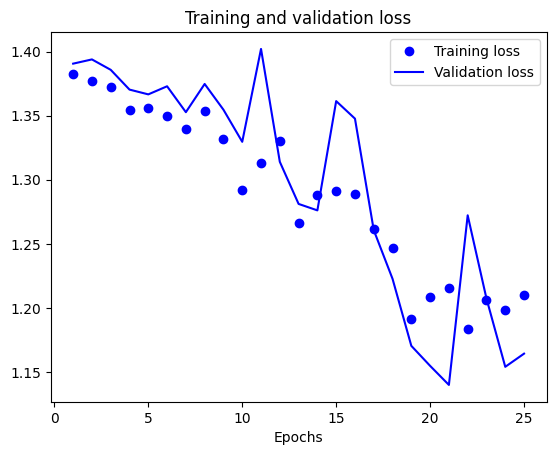

In [10]:
#Let's plot the behaviour of the training to see whats happening

# Plot training and validation loss
import matplotlib.pyplot as plt
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()
plt.show()

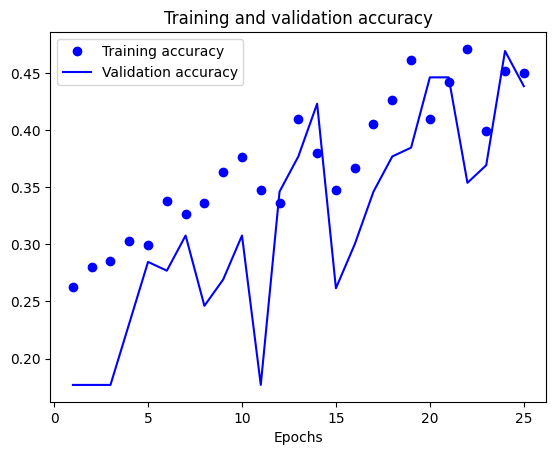

In [11]:
# Plot training and validation Accuracy
import matplotlib.pyplot as plt
loss = hist.history['accuracy']
val_loss = hist.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Step 2-2. Evaluate model

In [12]:
# make predictions
y_pred = VGG_ish_model.predict(X_test)
y_pred = y_pred.argmax(axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#Compute accuracy
print("Accuracy :",np.round(accuracy_score(y_test.argmax(axis=1), y_pred), 2))

Accuracy : 0.47


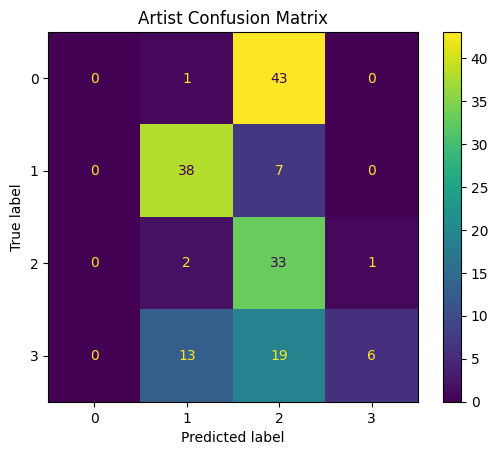

In [14]:
#Plot Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Artist Confusion Matrix')
plt.show()

#### Different experiments were executed, by changing layers in the model and adjusting the learning rate. In spite of this no greater accuracy than 50% was achieved.

# Step 3. Use a pre trained model as feature extractor and attach as classification head

## Step 3-1. Instantiate and Train new model

In [15]:
import keras
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# iterate through model layers and lock them to make them not trainable
# Except for the last 5th convolutional block
for layer in vggmodel.layers[:-5]:
    layer.trainable = False

vggmodel.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [17]:
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras.models import Model

# use “get_layer” method to save the last layer of the network
last_layer = vggmodel.get_layer('global_average_pooling2d')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 4 hidden units
x = Dense(4, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
tl_model = Model(inputs=vggmodel.input, outputs=x)
tl_model.name = "Transfer_Learning_model"

# print the new_model summary
tl_model.summary()

Model: "Transfer_Learning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 7,081,476 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [18]:
from tensorflow.keras.optimizers import Adam, SGD

acc_monitor = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.0001, patience=2)

#Compile new model
tl_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Train new model
hist_2 = tl_model.fit(x=X_train, y=y_train, batch_size=5, 
                      epochs=25, validation_split=0.2, callbacks=[acc_monitor])

Epoch 1/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.4572 - loss: 1.2324 - val_accuracy: 0.6154 - val_loss: 0.9922
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7525 - loss: 0.6976 - val_accuracy: 0.7692 - val_loss: 0.6192
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8493 - loss: 0.4017 - val_accuracy: 0.8231 - val_loss: 0.5426
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9264 - loss: 0.1944 - val_accuracy: 0.7462 - val_loss: 0.7932
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9813 - loss: 0.0912 - val_accuracy: 0.8000 - val_loss: 0.7310
Epoch 6/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9802 - loss: 0.0717 - val_accuracy: 0.7846 - val_loss: 0.8280
Epoch 7/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9817 - loss: 0.0587 - val_accuracy: 0.7769 - val_loss: 0.8788
Epoch 8/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9886 - loss: 0.0509 - val_ac

In [ ]:
#Let's plot the behaviour of the training to see whats happening

# Plot training and validation loss
import matplotlib.pyplot as plt
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Plot training and validation Accuracy
import matplotlib.pyplot as plt
loss = hist_2.history['accuracy']
val_loss = hist_2.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## Step 3-2. Evaluate new model

In [28]:
# make predictions
y_pred_2 = tl_model.predict(X_test)
#y_pred_2 = y_pred_2.argmax(axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#Compute accuracy
print("Accuracy :",np.round(accuracy_score(y_test.argmax(axis=1), y_pred_2.argmax(axis=1)), 2))

Accuracy : 0.91


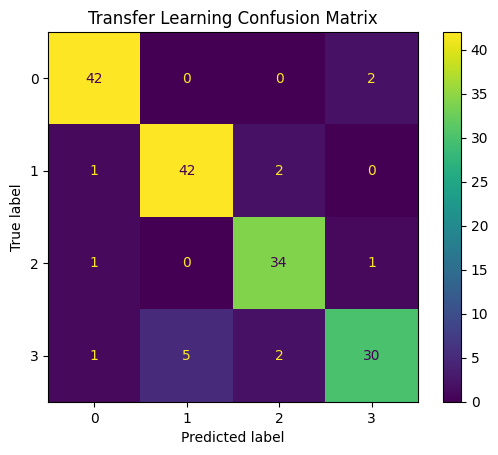

In [31]:
#Plot Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_2.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Transfer Learning Confusion Matrix')
plt.show()

In [47]:
from sklearn.metrics import f1_score
y_pred_3 = keras.utils.to_categorical(y_pred_2.argmax(axis=1), 4) 
f1_score(y_test, y_pred_3, average='weighted')

0.9068024757472312